In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from nn_utils import AE_big, AE_3D_200
from utils import plot_activations

In [2]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/uncompressed_4D_all_jets_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/uncompressed_4D_all_jets_test.pkl')
#n_features = len(train.loc[0])


#Remove zero mass jets
"""
for index, row in train.iterrows():
    if row["m"] == 0:
        train.drop([index])
        print("dropped")

for index, row in test.iterrows():
    if row["m"] == 0:
        test.drop([index])
"""
"""
train = train[train.m != 0]
test = test[test.m != 0]

train.head(10)

"""

train = train.loc[train["m"] > 0.08]
test = test.loc[test["m"] > 0.08]

train = train.loc[train["m"] < 15000]
test = test.loc[test["m"] < 15000]

#train = train.loc[train["pt"] > 10000]
#test = test.loc[test["pt"] > 10000]

#train = train.loc[train["pt"] < 25000]
#test = test.loc[test["pt"] < 25000]

#train = train.loc[train["pt"] > 25000]#.iloc(:1)
#test = test.loc[test["pt"] > 25000]

#Shuffle datasets
train = train.sample(frac=1)
test = test.sample(frac=1)

"""
def log_normalize(train, test=None):
    train['pt'] = train['pt'].apply(lambda x: x / 1000.)
    train['m'] = train['m'].apply(lambda x: x / 1000.)
    train['eta'] = train['eta'] / 1.
    train['phi'] = train['phi'] / 1.
    if test is not None:
        test['pt'] = test['pt'].apply(lambda x: x / 1000.)
        test['m'] = test['m'].apply(lambda x: x / 1000.)
        test['eta'] = test['eta'] / 1.
        test['phi'] = test['phi'] / 1.

        return train#.astype('float32'), test.astype('float32')
    else:
        return train#.astype('float32')
"""
# Normalize
#log_normalize(train, test)

# Custom normalization for AOD data
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2

centroidR_sub = 3

area4vecm_sub = 0.15


m_add = 1
pt_sub = 1.3
eta_div = 5
phi_div = 3

for data in [train,test]:
    #data['m'] = (np.log10(data['m'])-3.6)
    data['m'] = np.log10(data['m'] + m_add) / m_div -1.4
    data['eta'] = data['eta'] / eta_div
    
    data['phi'] = data['phi'] / phi_div
    
    #data['pt'] = (np.log10(data['pt']/1000-10)) -0.7
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div -2.4

train = train.loc[train["m"] > 0]
test = test.loc[test["m"] > 0]
    
#train_mean = train.mean()
#train_std = train.std()

#train = (train - train_mean) / train_std
#test = (test - train_mean) / train_std

#train = (train - train_mean)
#test = (test - train_mean) 


train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

#train.head(10)

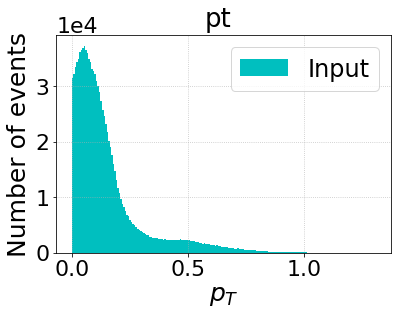

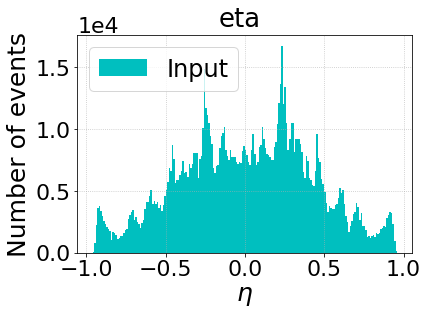

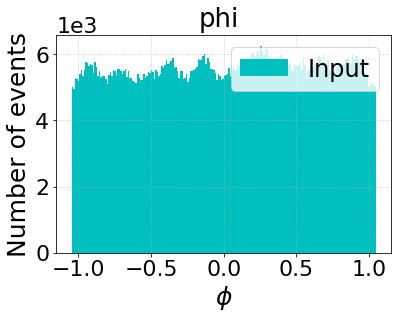

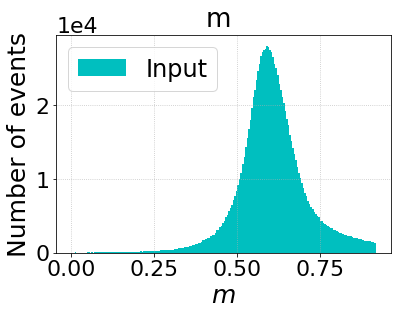

In [3]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pt","eta","phi","m"]

%matplotlib inline
n_bins = 200
alph = 0.8
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(branches[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [4]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)


class AE_3D_200_wide(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_wide, self).__init__()
        self.n = 200
        self.en1 = nn.Linear(n_features, self.n)
        self.en2 = nn.Linear(self.n, self.n)
        self.en3 = nn.Linear(self.n, self.n)
        self.en4 = nn.Linear(self.n, 3)
        self.de1 = nn.Linear(3, self.n)
        self.de2 = nn.Linear(self.n, self.n)
        self.de3 = nn.Linear(self.n, self.n)
        self.de4 = nn.Linear(self.n, n_features)
        self.tanh = nn.Tanh()
        

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-200-3-200-200-200-out'

model = AE_3D_200_wide(4).double()

#model = AE_3D_200().double()

loss_func = nn.MSELoss()


bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd =1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

#from fastai import train as tr
#tr.lr_find(learn)

#learn.recorder.plot()

In [5]:
lr = 1e-7
learn.fit(1, lr=lr, wd=wd)

lr = 1e-4
learn.fit(30, lr=lr, wd=wd)

#learn.save('uncompressed_4D')



epoch,train_loss,valid_loss,time
0,0.207230,0.206537,02:45


epoch,train_loss,valid_loss,time
0,0.000652,0.000635,03:39
1,0.000554,0.000542,03:29
2,0.000521,0.000523,04:07
3,0.000529,0.000529,03:56
4,0.000525,0.000525,03:47
5,0.000517,0.000514,03:34
6,0.000515,0.000504,02:43


KeyboardInterrupt: 

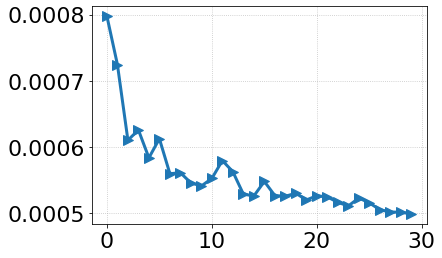

In [14]:
plt.plot(learn.recorder.val_losses, marker='>')

In [95]:
lr = 1e-4
learn.fit(500, lr=lr, wd=wd)

learn.save('uncompressed_4D')


epoch,train_loss,valid_loss,time
0,0.000844,0.000876,00:02
1,0.000838,0.000885,00:02
2,0.000825,0.000832,00:02
3,0.000829,0.000830,00:02
4,0.000828,0.000830,00:02


KeyboardInterrupt: 

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


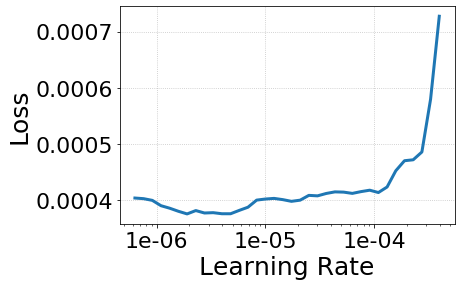

In [70]:
from fastai import train as tr
tr.lr_find(learn)

learn.recorder.plot()

In [71]:
lr = 1e-4
learn.fit(200, lr=lr, wd=wd)

learn.save('uncompressed_4D')


epoch,train_loss,valid_loss,time
0,0.000427,0.000441,00:43
1,0.000431,0.000426,00:39
2,0.000448,0.000425,00:41


KeyboardInterrupt: 

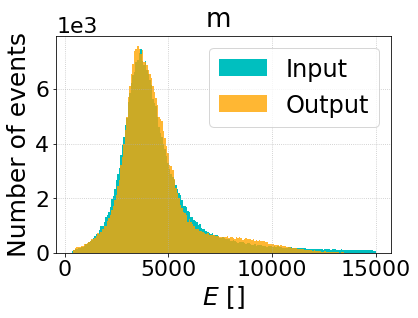

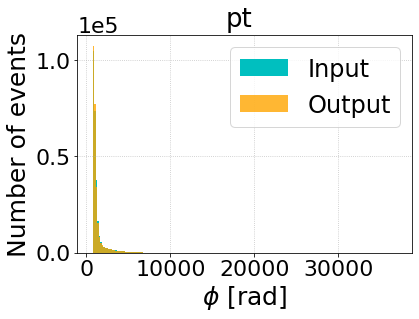

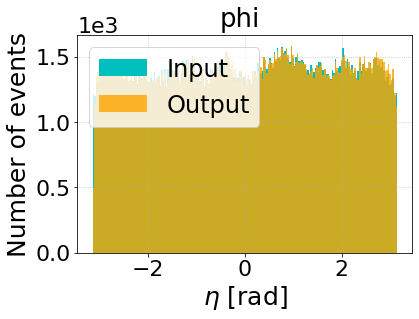

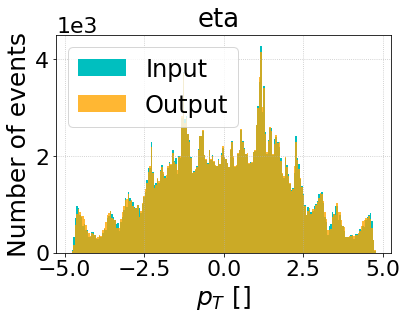

In [6]:
plt.close('all')
unit_list = ['[]', '[rad]', '[rad]', '[]']
variable_list = [r'$E$', r'$\phi$', r'$\eta$', r'$p_T$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')
#learn.load('uncompressed_4D')

# Histograms
idxs = (0, 1000000)  # Choose events to compare
#data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
data = torch.tensor(test_x.values)

pred = model(data).detach().numpy()

#pred = np.multiply(pred, train_std.values)
#pred = np.add(pred, train_mean.values)
"""
#pred[:, 3] = np.power(10,pred[:, 3]*3.)#pred[3].apply(lambda x: np.e**(x*3.))
#pred[:, 0] = np.power(10,pred[:, 0]*3.)#pred[0].apply(lambda x: np.e**(x*3.))
pred[:, 0] = pred[:, 0] * 3000.
pred[:, 3] = pred[:, 3] * 3000.
pred[:, 1] = pred[:, 1] * 3.
pred[:, 2] = pred[:, 2] * 3.

data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

#data[:, 3] = np.power(10,data[:, 3]*3.)#.apply(lambda x: np.e**(x*3.))
#data[:, 0] = np.power(10,data[:, 0]*3.)#data[0].apply(lambda x: np.e**(x*3.))
data[:, 1] = data[:, 1] * 3.
data[:, 2] = data[:, 2] * 3.
data[:, 3] = data[:, 3] * 3000.
data[:, 0] = data[:, 0] * 3000.
"""

"""
for d in [data,pred]:
    #d[:, 0] = 10**(d[:, 0] * m_div) - m_add
    d[:, 0] = np.power(10, m_div * d[:, 0]) - m_add
    d[:, 3] = d[:, 3] * eta_div
    d[:, 2] = d[:, 2] * phi_div
    d[:, 1] = np.power(10, pt_div * d[:, 1] + pt_sub)
"""
"""
for d in [data,pred]:
    #d[:, 0] = (np.power(10, (d[:, 0] -1.1)*m_div))*3000

    d[:, 3] = d[:, 3] * eta_div
    d[:, 2] = d[:, 2] * phi_div
    
    d[:, 1] = (np.power(10, d[:, 1])+1)
"""
for d in [data,pred]:
    #data['m'] = (np.log10(data['m'])-3.6)
    
    d[:, 0] = np.power(10,(d[:, 0]+1.4)*m_div)-m_add
    
    d[:, 3] = d[:, 3] * eta_div
    
    d[:, 2] = d[:, 2] *phi_div
    
    d[:, 1] = np.power(10,(d[:, 1]+2.4)*pt_div)+pt_sub

alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

[3363.535497 9768.825759 3423.910963 4465.932373 ... 3112.525023 3218.478158 7949.544108 4036.454188]
[3584.156738 6387.412598 3662.364502 4349.401855 ... 2736.82373  3384.274414 6330.280762 2309.374756]


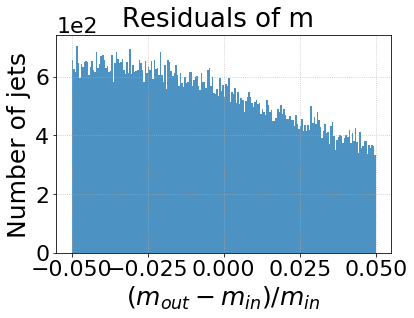

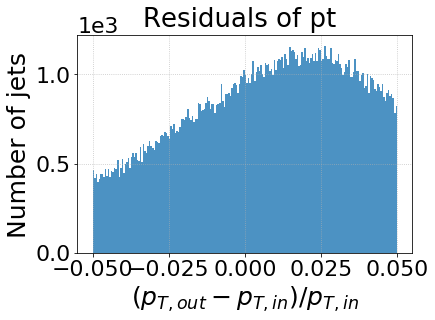

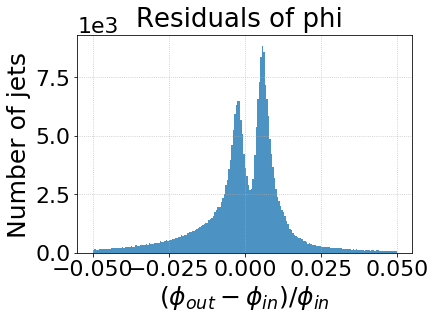

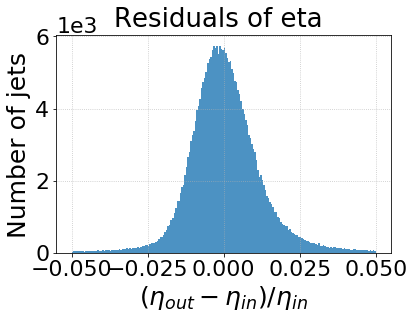

In [8]:
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                    r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$'
                        
                        ]
#residuals = (pred - data.detach().numpy()) / data.detach().numpy()


residuals = (pred - data.detach().numpy())/data.detach().numpy()

mres = (pred[:, 0] - data.detach().numpy()[:, 0])/data.detach().numpy()[:, 0]

print(pred[:, 0])
print(data.detach().numpy()[:, 0])

range = (-0.05, 0.05)
#range=None

for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=200, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    #plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
    #         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

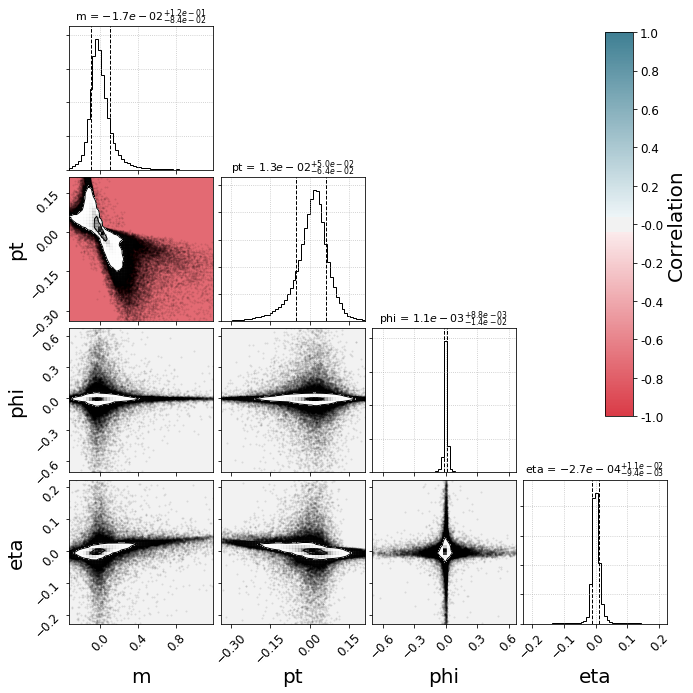

In [10]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'phi', 'eta']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)